# Импорт библиотек

In [1]:
#  Импортируем библиотеки, которые понадобяться в работе
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, re, joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AutoModelForSequenceClassification

# EDA

Проведем EDA (Exploratory Data Analysis) - Исследовательский Анализ Данных

In [2]:
# Загружаем датасет для изучения
df = pd.read_csv("intent_dataset.csv")
df

,text,intent
0,Хочу заказать пиццу пепперони и колу,order
1,Отмените мой последний заказ пожалуйста,cancel
2,Как оплатить заказ картой онлайн?,payment
3,"Курьер опоздал на 40 минут, требую компенсацию",complaint
4,Две пасты карбонара и салат цезарь на адрес Тв...,order
...,...,...
104,Закажите пиццу вегетарианскую,order
105,Атменить заказ #888,cancel
106,Оплата не проходит чз прил,payment
107,Пицца недопеченая!,complaint


In [3]:
# смотрим информацию о датасете и пропусках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    109 non-null    object
 1   intent  109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


видим что в предоставленных нам данных пропусков нет

In [4]:
# Смотрим статистику
df.describe()

,text,intent
count,109,109
unique,109,5
top,Хочу заказать пиццу пепперони и колу,order
freq,1,25


Видим из статистики что у нас 5 уникальных категорий намерений (intent) - наших классов, чаще всего встречается намерение order(заказ еды), а именно 25 раз. Посмотрим сколько раз встречаются остальные намерения:

* order - Заказ еды
* cancel - Отмена заказа
* payment - Оплата
* complaint - Жалоба
* other - Другие вопросы

In [5]:
df['intent'].value_counts()

intent
order        25
other        24
complaint    22
payment      20
cancel       18
Name: count, dtype: int64

видим, что меньше всего встречается намерение отмены заказа, а именно 18 раз. Для наглядности результатов дополнительно построим столбчатую диаграмму распределения классов.

Text(0.5, 1.0, 'Распределение классов')

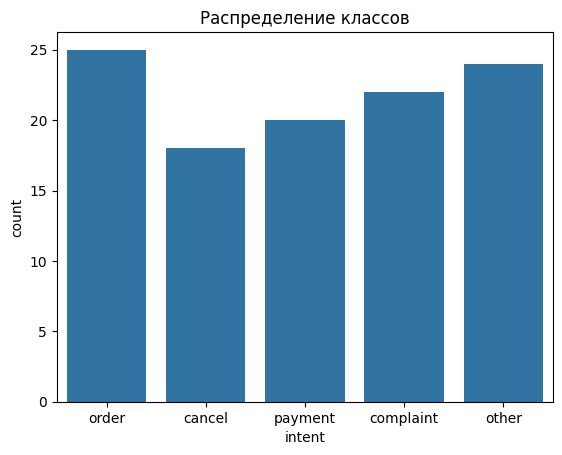

In [ ]:
sns.countplot(x='intent', data=df)
plt.title('Распределение классов')

я решил оставить двумя способами получение длины текста

Первый способ через обычный перебор, также здесь одновременно посчитаем ещё и частотность слов и символов

In [7]:
counter = [] # список для подсчета длины слов
words = {} # словарь частотности слов
symbols = {} # словарь частотности символов
for i in df['text']:
    i = str.lower(i) # приводим к нижнему регистру
    i = re.sub(r"[{}]".format(string.punctuation), "", i) # убираем пунктуацию
    a = [l for l in i.split(' ')]
    counter.append(len(a))
    for el in a:
        if el not in words:
            words[el]= 1
        else:
            words[el]+=1
    for l in i:
        if l not in symbols:
            symbols[l] = 1
        else:
            symbols[l] +=1
# произведем сортировку слов в словаре по убыванию
sorted_words =dict(sorted(words.items(), key=lambda item: item[1], reverse=True)) 
print("Средняя длина текста слов:", np.mean(counter))
print("Словарь частотности встречаемости слов отсортированный по убыванию:", sorted_words)
print("Словаь частотности символов:", symbols)

Средняя длина текста слов: 4.954128440366972
Словарь частотности встречаемости слов отсортированный по убыванию: {'заказ': 15, 'как': 13, 'на': 13, 'с': 13, 'не': 12, 'и': 11, 'в': 11, 'можно': 9, 'почему': 9, 'курьер': 8, 'отмените': 7, 'где': 6, 'к': 6, 'есть': 6, 'пиццу': 5, 'ли': 5, 'меню': 5, 'заказать': 4, 'мой': 4, 'оплатить': 4, 'две': 4, 'отмена': 4, 'оплата': 4, 'закажите': 4, 'подписку': 4, 'у': 4, 'вас': 4, 'закажи': 4, 'доставка': 4, 'хочу': 3, 'салат': 3, 'оплаты': 3, 'доставьте': 3, 'роллы': 3, 'уже': 3, 'заказа': 3, 'пожалуйста': 2, 'цезарь': 2, 'привезли': 2, 'верните': 2, 'деньги': 2, 'после': 2, 'изза': 2, 'суп': 2, 'больше': 2, 'был': 2, 'я': 2, 'передумал': 2, 'через': 2, 'пиццы': 2, 'доставкой': 2, 'проходит': 2, 'карты': 2, 'суши': 2, 'мне': 2, 'доставку': 2, 'бургера': 2, '4': 2, 'супе': 2, 'волос': 2, 'отменить': 2, 'персон': 2, 'для': 2, 'при': 2, 'нет': 2, 'кофе': 2, 'сколько': 2, 'еда': 2, 'глючит': 2, '2': 2, 'найти': 2, 'срочно': 2, 'пепперони': 1, 'колу':

In [8]:
# Второй способ, для вычисления длины текста, также записываем длину в наш Data Frame
df['text_len'] = df['text'].apply(lambda x: len(x.split()))
print("Средняя длина текста:", df['text_len'].mean())

Средняя длина текста: 4.954128440366972


## Стратегия обработки дисбаланса классов

Для работы с данными с дисбалансом классов можем, в первую очередь произвсти разделение данных с сохранением баланса классов (стратификация), можем использовать взвешивание весов классов, чтобы у нас при обучении модель обращала одинаковое внимание как на малочисленные, так и на многочисленные классы(делается с помощью class_weight='balanced')

# Классическая модель

Разделяем данные на train test 80 на 20 с сохранением баланса классов (стратификацией)

In [9]:
x,y = df['text'], df['intent']
# так же для разделения задаем специальный параметр random_state=42(чтобы при перезапуске были те же результаты)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42, stratify=y)

Пишем код для векторизации текста с помощью TF-IDF

In [10]:
# пропишем функцию предобработки, чтобы наш векторизатор приводил текст в единый стиль
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), "", line)
    return line

# прописываем векторизацию
vectorizer = TfidfVectorizer(preprocessor=preprocessing, ngram_range=(1,2), max_features=5000)
# обучаем векторизатор на нашем тексте
vectorizer.fit(df['text'])
# производим векторизацию train и test
x_train_vect = vectorizer.transform(x_train)
x_test_vect = vectorizer.transform(x_test)

Обучаем модель с учетом дисбаланса классов, class_weight ='balanced'

In [11]:
log_reg = LogisticRegression(class_weight='balanced', random_state=10, n_jobs=-1).fit(x_train_vect,y_train)

Произведем оценку качества модели используя метрики F1-macro

In [12]:
y_pred = log_reg.predict(x_test_vect)
f1_score(y_pred, y_test, average="macro")

0.6905194805194805

видим что точность получилось средняя, данной точности недостаточно будет для введния в пользование необходимо будет улучшать, выведем classification report для дальнейшего анализа

In [13]:
results_simple_log=classification_report(y_pred, y_test)
print(results_simple_log)

              precision    recall  f1-score   support

      cancel       0.75      1.00      0.86         3
   complaint       0.75      0.43      0.55         7
       order       0.60      1.00      0.75         3
       other       0.40      0.67      0.50         3
     payment       1.00      0.67      0.80         6

    accuracy                           0.68        22
   macro avg       0.70      0.75      0.69        22
weighted avg       0.75      0.68      0.68        22



из classification report видем что модель плохо предсказывает такие классы как: 
* other(другие вопросы) 0.4 precision и плохо его может отличить от остальных классов (0.67 recall); 
* order (заказ еды) 0.6 precision; 
* также можно увидеть что класс complaint имеет хорошую точность предсказания, но плохо различим от других классов recall 0.43

Выведем confusion matrix, чтобы проанализировать, как что у нас часто определяет неправильно

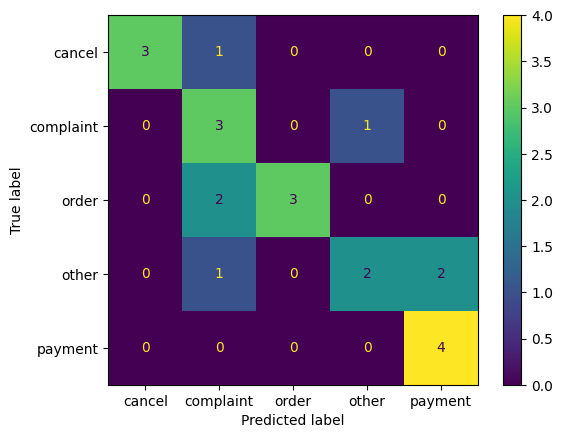

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg.classes_)
disp_log_reg.plot()
plt.show()

Так по матрице смежности можем увидеть что:
* у нас отмена в 1 случае была предсказана как жалоба; 
* Жалоба в 1 случае была предсказана как другой вопрос; 
* Заказ дважды был предсказан неверно как жалоба; 
* Другой вопрос был предсказан 1 раз как жалоба 2 раза как оплата. 

In [15]:
# запишем предсказанные значения и правильные метки в DataFrame
log_reg_pred = pd.DataFrame({
    'text': x_test.tolist(),
    'true_label': y_test.tolist(),
    'pred_label': y_pred.tolist()
})

In [16]:
# Сохраняем модель и Векторайзер
joblib.dump(vectorizer, 'models/vectorizer_log_reg.pkl', compress=True)
joblib.dump(log_reg, 'models/log_reg.pkl',)

['models/log_reg.pkl']

# Нейросетевая модель

Загружаем модель и её токенизатор

In [17]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

Вычисляем доступность видеокарты для ускорения обучения

In [18]:
print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
    
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Is CUDA supported by this system?True
CUDA version: 12.6
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2070 Super
How many devices 1


пишем функцию для вычисления векторных представлений текста (эмбедингов)

In [19]:
def encode_texts(texts, tokenizer, model, device='cpu', batch_size=16):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            # Получаем эмбеддинги токенов (batch_size x seq_len x hidden_size)
            token_embeddings = outputs.last_hidden_state  # [B, T, H]
            # Усредняем по всем токенам
            attention_mask = inputs['attention_mask'].unsqueeze(-1).expand(token_embeddings.size())
            sum_embeddings = (token_embeddings * attention_mask).sum(dim=1)
            sum_mask = attention_mask.sum(dim=1)
            sentence_embeddings = sum_embeddings / sum_mask

            embeddings.append(sentence_embeddings.cpu().numpy())

    return np.vstack(embeddings)

# вычисляем эмбединги применяя написанную нами функцию
X_train_emb = encode_texts(x_train.tolist(), tokenizer, model)
X_test_emb = encode_texts(x_test.tolist(), tokenizer, model)

100%|██████████| 2/2 [00:00<00:00, 15.03it/s]


## Строим простую модель классификатора поверх эмбеддингов

In [20]:
log_reg_bert = LogisticRegression(class_weight='balanced', random_state=10, n_jobs=-1).fit(X_train_emb, y_train)
y_pred = log_reg_bert.predict(X_test_emb) # предсказываем значения

In [21]:
# выводим метрики по обученной модели
log_reg_bert_results = classification_report(y_test, y_pred)
print("F1-macro:", f1_score(y_test, y_pred, average='macro'))
print(log_reg_bert_results)

F1-macro: 0.6868686868686867
              precision    recall  f1-score   support

      cancel       1.00      0.50      0.67         4
   complaint       0.43      0.75      0.55         4
       order       1.00      0.80      0.89         5
       other       0.75      0.60      0.67         5
     payment       0.60      0.75      0.67         4

    accuracy                           0.68        22
   macro avg       0.76      0.68      0.69        22
weighted avg       0.77      0.68      0.70        22



видим что наша модель предсказывает с точностью 69% все классы, при этом плохо обучилась предсказывать complaint(43%) и payment(60%), также можно заметить моделе тяжело отделить cancel от других классов(recall 50%)

Выведем confusion matrix, чтобы проанализировать, как что у нас часто определяет неправильно

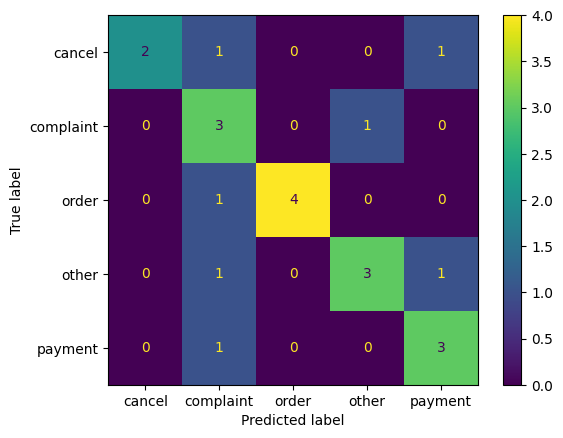

In [22]:
cm = confusion_matrix(y_test, y_pred, labels=log_reg_bert.classes_)
disp_log_reg_bert = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg_bert.classes_)
disp_log_reg_bert.plot()
plt.show()

Так по матрице смежности можем увидеть что:
* у нас отмена в 1 случае была предсказана как жалоба, в 1 случае как платеж
* Жалоба в 1 случае была предсказана как другой вопрос; 
* Заказ 1 раз был предсказан неверно как жалоба; 
* Другой вопрос был предсказан 1 раз как жалоба, 1 раза как оплата.
* Платеж был предсказан 1 раз как жалоба 

In [23]:
# запишем предсказанные значения и правильные метки в DataFrame
log_reg_bert_pred = pd.DataFrame({
    'text': x_test.tolist(),
    'true_label': y_test.tolist(),
    'pred_label': y_pred.tolist()
})

In [24]:
# Сохраняем модель
joblib.dump(log_reg_bert, 'models/log_reg_bert.pkl',)

['models/log_reg_bert.pkl']

## Строю простую нейронную сеть с добавлением слоев Dense

слой Dense по сути в pytorch это линейный слой nn.Linear

Произведем перекодирование таргетов с помощью label Encoder, переведем их таким образом в числа на основе первой встречи

In [25]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
# запишем глобальные переменные для сети, количество классов, и входных значений(input_dim) 
NUM_CLASSES= len(le.classes_)
INPUT_DIM = X_train_emb.shape[1]
print(NUM_CLASSES, INPUT_DIM)

5 384


In [26]:
# Класс для создания датасета
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx])

# создаем свой датасет и загрузчики данных в модель постепенные 
train_dataset = CustomDataset(X_train_emb,y_train_le)
test_dataset = CustomDataset(X_test_emb, y_test_le)
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [27]:
# Напишем свою реализацию модели Logistic она будет представлять из себя архитектуру
# логистической регрессии, но с двумя добавленными линейными слоями
class ClassifierLogistic(nn.Module):
    def __init__(self, input_dim,output_dim, hidden_dim=256):
        super().__init__()
        hidden_dim_2 = hidden_dim//2
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.dropout = nn.Dropout(0.3)

    # прописываем прямой проход модели, операции через которые будут прогоняться данные
    # чтобы модель училась  
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [28]:
# инициализируем модель
logistic = ClassifierLogistic(input_dim=INPUT_DIM, output_dim=NUM_CLASSES).to(device)
# выбераем функцию потерь для обучения модели CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# Как оптимизатор возьмем Adam
optimizer = torch.optim.Adam(logistic.parameters(), lr=2e-4)

# так как модель слабая, будем прогонять её 100 эпох
EPOCHS = 100
for epoch in range(EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    logistic.train()
    total_loss = 0
    for X_batch, y_batch in train_data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits =logistic(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 0/100
Epoch 1, Loss: 1.5884
Epoch 1, Loss: 3.1894
Epoch 1, Loss: 4.8164
Epoch 1, Loss: 6.4077
Epoch 1, Loss: 8.0256
Epoch 1, Loss: 9.6405
Epoch 1/100
Epoch 2, Loss: 1.6088
Epoch 2, Loss: 3.2056
Epoch 2, Loss: 4.7919
Epoch 2, Loss: 6.3832
Epoch 2, Loss: 7.9908
Epoch 2, Loss: 9.5826
Epoch 2/100
Epoch 3, Loss: 1.6028
Epoch 3, Loss: 3.1948
Epoch 3, Loss: 4.7948
Epoch 3, Loss: 6.3704
Epoch 3, Loss: 7.9440
Epoch 3, Loss: 9.5095
Epoch 3/100
Epoch 4, Loss: 1.5814
Epoch 4, Loss: 3.1662
Epoch 4, Loss: 4.7345
Epoch 4, Loss: 6.3123
Epoch 4, Loss: 7.8854
Epoch 4, Loss: 9.4811
Epoch 4/100
Epoch 5, Loss: 1.5968
Epoch 5, Loss: 3.1409
Epoch 5, Loss: 4.6936
Epoch 5, Loss: 6.2780
Epoch 5, Loss: 7.8444
Epoch 5, Loss: 9.4485
Epoch 5/100
Epoch 6, Loss: 1.5738
Epoch 6, Loss: 3.1177
Epoch 6, Loss: 4.6989
Epoch 6, Loss: 6.2663
Epoch 6, Loss: 7.8246
Epoch 6, Loss: 9.3733
Epoch 6/100
Epoch 7, Loss: 1.5217
Epoch 7, Loss: 3.1001
Epoch 7, Loss: 4.6550
Epoch 7, Loss: 6.1881
Epoch 7, Loss: 7.7533
Epoch 7, Loss:

вычисляем точность модели

In [29]:
logistic.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_data_loader:
        X_batch = X_batch.to(device)
        logits = logistic(X_batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

logistic_result = classification_report(all_true, all_preds, target_names=le.classes_)
print("F1-macro:", f1_score(all_true, all_preds, average='macro'))
print(logistic_result)

F1-macro: 0.7897258297258298
              precision    recall  f1-score   support

      cancel       1.00      0.75      0.86         4
   complaint       0.43      0.75      0.55         4
       order       1.00      0.80      0.89         5
       other       0.80      0.80      0.80         5
     payment       1.00      0.75      0.86         4

    accuracy                           0.77        22
   macro avg       0.85      0.77      0.79        22
weighted avg       0.85      0.77      0.79        22



Посмотрев на результаты можем увидеть что модель хорошо обучилась, показывает точность на всех классах 0.79 %, плохо предсказывает только жалобы(0.43%)

In [30]:
# сохраняем результаты предсказаний в DataFrame
logistic_pred = pd.DataFrame({
    'text': x_test.tolist(),
    'true_label': le.inverse_transform(all_true),
    'pred_label': le.inverse_transform(all_preds)
})

In [31]:
# Сохраняем модель, LabelEncoder
torch.save(logistic.state_dict(), 'models/logistic_model.pt')
joblib.dump(le, 'models/label_encoder.pkl')

['models/label_encoder.pkl']

## Дообучаем нейронную сеть трансформер

Напишем ещё одну модель трансформер, для неё мы реализуем класс Dataset другой, так как будем полностью дообучать архитектуру, и она отличается от нашей прошлой архитектуры, для них необходимы разные подготовки

In [32]:
class DatasetTune(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            padding='max_length',
            truncation=True,
            max_length = self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
train_dataset = DatasetTune(x_train.tolist(), y_train_le.tolist(), tokenizer)
test_dataset = DatasetTune(x_test.tolist(), y_test_le.tolist(), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Обучаем модель

In [33]:
model = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/all-MiniLM-L6-v2', num_labels=NUM_CLASSES).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 6/6 [00:00<00:00,  9.69it/s]


Epoch 1, Loss: 9.6363


100%|██████████| 6/6 [00:00<00:00, 21.63it/s]


Epoch 2, Loss: 9.5650


100%|██████████| 6/6 [00:00<00:00, 19.46it/s]


Epoch 3, Loss: 9.4715


100%|██████████| 6/6 [00:00<00:00, 20.14it/s]


Epoch 4, Loss: 9.4383


100%|██████████| 6/6 [00:00<00:00, 21.69it/s]


Epoch 5, Loss: 9.2787


100%|██████████| 6/6 [00:00<00:00, 22.17it/s]


Epoch 6, Loss: 9.1483


100%|██████████| 6/6 [00:00<00:00, 22.21it/s]


Epoch 7, Loss: 8.8585


100%|██████████| 6/6 [00:00<00:00, 23.08it/s]


Epoch 8, Loss: 8.6057


100%|██████████| 6/6 [00:00<00:00, 21.99it/s]


Epoch 9, Loss: 8.2347


100%|██████████| 6/6 [00:00<00:00, 22.06it/s]


Epoch 10, Loss: 7.9460


100%|██████████| 6/6 [00:00<00:00, 18.68it/s]


Epoch 11, Loss: 7.4696


100%|██████████| 6/6 [00:00<00:00, 23.14it/s]


Epoch 12, Loss: 7.1077


100%|██████████| 6/6 [00:00<00:00, 23.02it/s]


Epoch 13, Loss: 6.6943


100%|██████████| 6/6 [00:00<00:00, 22.31it/s]


Epoch 14, Loss: 6.2691


100%|██████████| 6/6 [00:00<00:00, 22.41it/s]


Epoch 15, Loss: 5.8950


100%|██████████| 6/6 [00:00<00:00, 22.03it/s]


Epoch 16, Loss: 5.6790


100%|██████████| 6/6 [00:00<00:00, 22.96it/s]


Epoch 17, Loss: 5.2638


100%|██████████| 6/6 [00:00<00:00, 23.10it/s]


Epoch 18, Loss: 5.0706


100%|██████████| 6/6 [00:00<00:00, 21.89it/s]


Epoch 19, Loss: 4.7528


100%|██████████| 6/6 [00:00<00:00, 22.17it/s]


Epoch 20, Loss: 4.4578


100%|██████████| 6/6 [00:00<00:00, 22.83it/s]


Epoch 21, Loss: 4.0424


100%|██████████| 6/6 [00:00<00:00, 20.71it/s]


Epoch 22, Loss: 3.8688


100%|██████████| 6/6 [00:00<00:00, 23.11it/s]


Epoch 23, Loss: 3.5832


100%|██████████| 6/6 [00:00<00:00, 22.64it/s]


Epoch 24, Loss: 3.2962


100%|██████████| 6/6 [00:00<00:00, 22.02it/s]


Epoch 25, Loss: 2.9157


100%|██████████| 6/6 [00:00<00:00, 22.61it/s]


Epoch 26, Loss: 2.8512


100%|██████████| 6/6 [00:00<00:00, 22.48it/s]


Epoch 27, Loss: 2.5806


100%|██████████| 6/6 [00:00<00:00, 21.23it/s]


Epoch 28, Loss: 2.3275


100%|██████████| 6/6 [00:00<00:00, 20.51it/s]


Epoch 29, Loss: 2.1464


100%|██████████| 6/6 [00:00<00:00, 21.82it/s]


Epoch 30, Loss: 1.9663


100%|██████████| 6/6 [00:00<00:00, 22.78it/s]


Epoch 31, Loss: 1.8668


100%|██████████| 6/6 [00:00<00:00, 22.24it/s]


Epoch 32, Loss: 1.6900


100%|██████████| 6/6 [00:00<00:00, 22.80it/s]


Epoch 33, Loss: 1.6025


100%|██████████| 6/6 [00:00<00:00, 22.51it/s]


Epoch 34, Loss: 1.5534


100%|██████████| 6/6 [00:00<00:00, 22.31it/s]


Epoch 35, Loss: 1.4103


100%|██████████| 6/6 [00:00<00:00, 19.69it/s]


Epoch 36, Loss: 1.3374


100%|██████████| 6/6 [00:00<00:00, 22.26it/s]


Epoch 37, Loss: 1.2649


100%|██████████| 6/6 [00:00<00:00, 22.87it/s]


Epoch 38, Loss: 1.1660


100%|██████████| 6/6 [00:00<00:00, 22.61it/s]


Epoch 39, Loss: 1.1000


100%|██████████| 6/6 [00:00<00:00, 23.13it/s]


Epoch 40, Loss: 1.0465


100%|██████████| 6/6 [00:00<00:00, 22.72it/s]


Epoch 41, Loss: 0.9747


100%|██████████| 6/6 [00:00<00:00, 23.13it/s]


Epoch 42, Loss: 0.9175


100%|██████████| 6/6 [00:00<00:00, 22.98it/s]


Epoch 43, Loss: 0.8759


100%|██████████| 6/6 [00:00<00:00, 22.41it/s]


Epoch 44, Loss: 0.8386


100%|██████████| 6/6 [00:00<00:00, 22.88it/s]


Epoch 45, Loss: 0.8039


100%|██████████| 6/6 [00:00<00:00, 23.04it/s]


Epoch 46, Loss: 0.7810


100%|██████████| 6/6 [00:00<00:00, 20.90it/s]


Epoch 47, Loss: 0.7344


100%|██████████| 6/6 [00:00<00:00, 22.55it/s]


Epoch 48, Loss: 0.7170


100%|██████████| 6/6 [00:00<00:00, 22.18it/s]


Epoch 49, Loss: 0.6781


100%|██████████| 6/6 [00:00<00:00, 22.70it/s]


Epoch 50, Loss: 0.6579


100%|██████████| 6/6 [00:00<00:00, 23.18it/s]


Epoch 51, Loss: 0.6335


100%|██████████| 6/6 [00:00<00:00, 22.56it/s]


Epoch 52, Loss: 0.6101


100%|██████████| 6/6 [00:00<00:00, 23.19it/s]


Epoch 53, Loss: 0.5942


100%|██████████| 6/6 [00:00<00:00, 22.78it/s]


Epoch 54, Loss: 0.5688


100%|██████████| 6/6 [00:00<00:00, 22.20it/s]


Epoch 55, Loss: 0.5449


100%|██████████| 6/6 [00:00<00:00, 21.85it/s]


Epoch 56, Loss: 0.5232


100%|██████████| 6/6 [00:00<00:00, 22.18it/s]


Epoch 57, Loss: 0.5047


100%|██████████| 6/6 [00:00<00:00, 21.88it/s]


Epoch 58, Loss: 0.4792


100%|██████████| 6/6 [00:00<00:00, 22.39it/s]


Epoch 59, Loss: 0.4683


100%|██████████| 6/6 [00:00<00:00, 22.52it/s]


Epoch 60, Loss: 0.4621


100%|██████████| 6/6 [00:00<00:00, 22.72it/s]


Epoch 61, Loss: 0.4495


100%|██████████| 6/6 [00:00<00:00, 22.79it/s]


Epoch 62, Loss: 0.4315


100%|██████████| 6/6 [00:00<00:00, 21.99it/s]


Epoch 63, Loss: 0.4232


100%|██████████| 6/6 [00:00<00:00, 22.30it/s]


Epoch 64, Loss: 0.4119


100%|██████████| 6/6 [00:00<00:00, 22.68it/s]


Epoch 65, Loss: 0.3987


100%|██████████| 6/6 [00:00<00:00, 22.54it/s]


Epoch 66, Loss: 0.3860


100%|██████████| 6/6 [00:00<00:00, 22.35it/s]


Epoch 67, Loss: 0.3599


100%|██████████| 6/6 [00:00<00:00, 22.49it/s]


Epoch 68, Loss: 0.3659


100%|██████████| 6/6 [00:00<00:00, 22.77it/s]


Epoch 69, Loss: 0.3608


100%|██████████| 6/6 [00:00<00:00, 21.91it/s]


Epoch 70, Loss: 0.3360


100%|██████████| 6/6 [00:00<00:00, 21.74it/s]


Epoch 71, Loss: 0.3336


100%|██████████| 6/6 [00:00<00:00, 22.54it/s]


Epoch 72, Loss: 0.3259


100%|██████████| 6/6 [00:00<00:00, 22.72it/s]


Epoch 73, Loss: 0.3168


100%|██████████| 6/6 [00:00<00:00, 22.85it/s]


Epoch 74, Loss: 0.3110


100%|██████████| 6/6 [00:00<00:00, 23.16it/s]


Epoch 75, Loss: 0.3090


100%|██████████| 6/6 [00:00<00:00, 22.55it/s]


Epoch 76, Loss: 0.2951


100%|██████████| 6/6 [00:00<00:00, 22.51it/s]


Epoch 77, Loss: 0.2829


100%|██████████| 6/6 [00:00<00:00, 22.12it/s]


Epoch 78, Loss: 0.2838


100%|██████████| 6/6 [00:00<00:00, 22.55it/s]


Epoch 79, Loss: 0.2738


100%|██████████| 6/6 [00:00<00:00, 22.02it/s]


Epoch 80, Loss: 0.2739


100%|██████████| 6/6 [00:00<00:00, 22.21it/s]


Epoch 81, Loss: 0.2587


100%|██████████| 6/6 [00:00<00:00, 22.33it/s]


Epoch 82, Loss: 0.2564


100%|██████████| 6/6 [00:00<00:00, 22.64it/s]


Epoch 83, Loss: 0.2428


100%|██████████| 6/6 [00:00<00:00, 22.25it/s]


Epoch 84, Loss: 0.2467


100%|██████████| 6/6 [00:00<00:00, 22.09it/s]


Epoch 85, Loss: 0.2386


100%|██████████| 6/6 [00:00<00:00, 22.09it/s]


Epoch 86, Loss: 0.2350


100%|██████████| 6/6 [00:00<00:00, 22.52it/s]


Epoch 87, Loss: 0.2277


100%|██████████| 6/6 [00:00<00:00, 23.06it/s]


Epoch 88, Loss: 0.2232


100%|██████████| 6/6 [00:00<00:00, 23.07it/s]


Epoch 89, Loss: 0.2190


100%|██████████| 6/6 [00:00<00:00, 22.07it/s]


Epoch 90, Loss: 0.2127


100%|██████████| 6/6 [00:00<00:00, 22.12it/s]


Epoch 91, Loss: 0.2110


100%|██████████| 6/6 [00:00<00:00, 22.51it/s]


Epoch 92, Loss: 0.2019


100%|██████████| 6/6 [00:00<00:00, 21.99it/s]


Epoch 93, Loss: 0.2079


100%|██████████| 6/6 [00:00<00:00, 22.69it/s]


Epoch 94, Loss: 0.1985


100%|██████████| 6/6 [00:00<00:00, 22.86it/s]


Epoch 95, Loss: 0.1920


100%|██████████| 6/6 [00:00<00:00, 22.36it/s]


Epoch 96, Loss: 0.1901


100%|██████████| 6/6 [00:00<00:00, 22.73it/s]


Epoch 97, Loss: 0.1888


100%|██████████| 6/6 [00:00<00:00, 22.57it/s]


Epoch 98, Loss: 0.1866


100%|██████████| 6/6 [00:00<00:00, 21.46it/s]


Epoch 99, Loss: 0.1794


100%|██████████| 6/6 [00:00<00:00, 22.89it/s]

Epoch 100, Loss: 0.1759


Вычисляем точность модели

In [34]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

f1 = f1_score(all_true, all_preds, average='macro')
transformer_results = classification_report(all_true, all_preds, target_names=le.classes_, zero_division=True)
print(f"F1-macro: {f1:.4f}")
print(transformer_results)

F1-macro: 0.8656
              precision    recall  f1-score   support

      cancel       1.00      1.00      1.00         4
   complaint       0.67      1.00      0.80         4
       order       1.00      0.80      0.89         5
       other       1.00      0.80      0.89         5
     payment       0.75      0.75      0.75         4

    accuracy                           0.86        22
   macro avg       0.88      0.87      0.87        22
weighted avg       0.89      0.86      0.87        22



Посмотрев на результаты можем увидеть что модель хорошо обучилась, показывает точность на всех классах 87 %, плохо предсказывает только жалобы(67%)

In [35]:
# сохраняем предсказания модели в dataframe  
transformer_pred = pd.DataFrame({
    'text': x_test.tolist(),
    'true_label': le.inverse_transform(all_true),
    'pred_label': le.inverse_transform(all_preds)
})

In [36]:
# Сохраняем модель
model.save_pretrained('models/minilm_classifier/')
tokenizer.save_pretrained('models/minilm_classifier/')

('models/minilm_classifier/tokenizer_config.json',
 'models/minilm_classifier/special_tokens_map.json',
 'models/minilm_classifier/vocab.txt',
 'models/minilm_classifier/added_tokens.json',
 'models/minilm_classifier/tokenizer.json')

# Анализ и улучшения

## Сравнение результатов 4-х вариаций модели

Logistic Regression простой, классическая модель

In [37]:
print(results_simple_log)

              precision    recall  f1-score   support

      cancel       0.75      1.00      0.86         3
   complaint       0.75      0.43      0.55         7
       order       0.60      1.00      0.75         3
       other       0.40      0.67      0.50         3
     payment       1.00      0.67      0.80         6

    accuracy                           0.68        22
   macro avg       0.70      0.75      0.69        22
weighted avg       0.75      0.68      0.68        22



Logistic Regression с bert-эмбеддингами

In [38]:
print(log_reg_bert_results)

              precision    recall  f1-score   support

      cancel       1.00      0.50      0.67         4
   complaint       0.43      0.75      0.55         4
       order       1.00      0.80      0.89         5
       other       0.75      0.60      0.67         5
     payment       0.60      0.75      0.67         4

    accuracy                           0.68        22
   macro avg       0.76      0.68      0.69        22
weighted avg       0.77      0.68      0.70        22



самописная реализация Logistic Regression с двумя доп слоями линейными

In [39]:
print(logistic_result)

              precision    recall  f1-score   support

      cancel       1.00      0.75      0.86         4
   complaint       0.43      0.75      0.55         4
       order       1.00      0.80      0.89         5
       other       0.80      0.80      0.80         5
     payment       1.00      0.75      0.86         4

    accuracy                           0.77        22
   macro avg       0.85      0.77      0.79        22
weighted avg       0.85      0.77      0.79        22



Дообученная сеть трансформер

In [40]:
print(transformer_results)

              precision    recall  f1-score   support

      cancel       1.00      1.00      1.00         4
   complaint       0.67      1.00      0.80         4
       order       1.00      0.80      0.89         5
       other       1.00      0.80      0.89         5
     payment       0.75      0.75      0.75         4

    accuracy                           0.86        22
   macro avg       0.88      0.87      0.87        22
weighted avg       0.89      0.86      0.87        22



### выведем таблицу ошибок каждой из моделей

In [41]:
pred_tables =[log_reg_pred, log_reg_bert_pred, logistic_pred, transformer_pred] 
erors_dfs = []
for el in pred_tables:
    eror_df = el[el['true_label'] != el['pred_label']]
    erors_dfs.append(eror_df)

In [42]:
# Первая таблица по простой логистической регрессии
erors_dfs[0]

,text,true_label,pred_label
4,Как устроиться к вам курьером?,other,payment
10,Самса с говядиной 4 шт и лагман,order,complaint
13,Как связаться с техподдержкой?,other,payment
14,"В чеке ошибка, сумма не совпадает с меню",complaint,other
16,Отмени всё к чертям,cancel,complaint
19,Бургер и кола,order,complaint
21,Где найти состав блюд?,other,complaint


из таблицы видим что модель часто ошибается, относя заказ к другим меткам и не может проследить зависимости, негативный тон относит к жалабам. Также если текст начинается с еды аналогично считает, что будет жалоба. И вообще выглядит так что модель пытается всегда больше предсказывать complaint(то есть переобучилось предсказывать данный класс)

In [43]:
# таблица по логистической регрессии с токенизацией от трансформера
erors_dfs[1]

,text,true_label,pred_label
4,Как устроиться к вам курьером?,other,complaint
13,Как связаться с техподдержкой?,other,payment
14,"В чеке ошибка, сумма не совпадает с меню",complaint,other
16,Отмени всё к чертям,cancel,complaint
17,"Отмените подписку на кофе, больше не нужно",cancel,payment
19,Бургер и кола,order,complaint
20,Не могу найти где оплатить,payment,complaint


здесь уже видно что модель стала чуть умнее, но начала ошибаться в тех случаях когда смежные, то есть например: Отмени подписку (можно было отнести как и к платежам, так и к отмене заказа), "Не могу найти где оплатить" (можно было отнести как к платежам, так и к жалобе, что тяжело найти место в приложении).

In [44]:
# таблица по самописной логистической регрессии с токенизацией от трансформера и двумя доп слоями линейными
erors_dfs[2]

,text,true_label,pred_label
13,Как связаться с техподдержкой?,other,complaint
14,"В чеке ошибка, сумма не совпадает с меню",complaint,other
16,Отмени всё к чертям,cancel,complaint
19,Бургер и кола,order,complaint
20,Не могу найти где оплатить,payment,complaint


Модель стала ещё реже ошибаться, и как мы видим тоже переобучена на предсказание complaint

In [45]:
# Fine tune модели all-MiniLM-L6-v2
erors_dfs[3]

,text,true_label,pred_label
2,Срочно нужен кофе!,order,complaint
4,Как устроиться к вам курьером?,other,payment
20,Не могу найти где оплатить,payment,complaint


здесь мы можем увидеть, что модель стала ещё лучше, встречаются забавные случаи что модель, предполагает что если предложение в повелительном наклонении значит это жалоба, но всё также не может справиться с граничными случаями

### Выводы

* Как видим из результатов Logistic Regression и Logistic Regression с эмбедингами от трансформера дали идентичные результаты никакой разницы не случилось.
* Самописная реализация модели Logistic Regression с двумя дополнительными линейными слоями (Dense в tensorflow, но я пишу на Pytorch, где это Linear) показала точность выше первых двух на 10 % на всех классах, стала лучше предсказывать other и payment, но всё также плохо предсказывает класс complaint.
* Дообучение модели трансформерной архитектуры all-MiniLM-L6-v2 показало точность выше самописной реализации Logistic Regression на 3% на всех классах, стала лучше предсказывать complaint, но точность по payments уменьшилась.



В целом архитектура нейронной сети когда мы получаем эмбединги с помощью трансформерного токенизатора а не с помощью TF-IDF мы получаем больший прирост за счёт того что модель воспринимает нюансы в контексте, и может легко обрабатывать как тексты с опечаткой так и сленговые выражения

## Улучшения

1. Добавить fallback, то есть если модель не уверен в точности отправлять для уточнения запросы.
2. отправлять проверяющему для проверки правилность классификации в случаях маленькой точности, тем самым записывать утверждения человека для дообучения модели
3. Добавить взаимодействие с RAG(то есть добавить информацию и контекста модели, чтобы она искала по базе знаний, документы, меню и т.д.)

Для обработки edge-кейсов можно попробовать обучить отдельный детектор надстройку над моделью для таких случаев, чтобы появилась возможность понимать, что не просто отмена, а отмена чего именно(отмена заказа, отмена платежа)
По пользовательскому запросу ищем близкие отрывки (из меню, политики, FAQ) с помощью RAG и передаем в контекст модели, чтобы она генерировала более коректный ответ, производила более точную классификацию.